In [30]:
import numpy as np
import random
import torch
import os
import spacy
from torchtext.vocab import GloVe, FastText
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import math
from torchsummary import summary

In [2]:
def set_seed(seed = 42):
    '''
        For Reproducibility: Sets the seed of the entire notebook.
    '''

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    # Sets a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(1)


In [3]:
dataset_file = open("./Assignment2aDataset.txt", "r").read()
dataset_lines = dataset_file.splitlines()

dataset = []
for line in dataset_lines:
    x, y = line.split(',')
    x, y = x.lower().strip()[1:-1], y.lower().strip()[1:-1]
    
    if '/' in x:
        x = x.split('/')
    else:
        x = x.split(' ')
        
    dataset.append((x, y))

In [4]:
dataset_preprocessed = []

for x, y in dataset:

    x_prepro = []
    for word in x:
        x_prepro.append(word)

    labels = []
    for label in y:
        if label == '-':
            labels.append(10)
        else:
            labels.append(int(label))
    dataset_preprocessed.append((x_prepro, labels))

In [5]:
labels

[1, 7, 1, 2, 10, 0, 1, 10, 2, 7]

In [6]:
vocabulary = set()
vocab_to_ids = {}
ids = 1
for x, y in dataset_preprocessed:
    for i in x:
        vocabulary.add(i)
        if i not in vocab_to_ids:
            vocab_to_ids[i] = ids
            ids += 1
vocab_to_ids['unk'] = ids

In [7]:
dataset_corpus = []
for x, y in dataset_preprocessed:
    x_ids = []
    for i in x:
        x_ids.append(vocab_to_ids[i])
    dataset_corpus.append((x_ids, y))

In [8]:
# Downloads GloVe and FastText
global_vectors = GloVe(name='840B', dim=300)

emb_dim = 300
embeds = torch.zeros(len(vocab_to_ids) + 1, emb_dim)

for token, idx in vocab_to_ids.items():
    embeds[idx] = global_vectors[token] 

In [9]:
# Train-Valid split of 80-20
def split_indices(n, val_pct):

    # Determine size of Validation set
    n_val = int(val_pct * n)

    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

train_indices, val_indices = split_indices(len(dataset_corpus), 0.2)

In [10]:
from torch.nn.utils.rnn import pad_sequence

# ----------- Batching the data -----------
def collate_fn(instn):
    sentence = [torch.Tensor(x[0]) for x in instn]
    labels = torch.Tensor([x[1] for x in instn])

    padded_sent = pad_sequence(sentence, batch_first=True, padding_value=0)

    l = torch.cat((labels[:, 0], labels[:, 1],labels[:, 2],labels[:, 3],labels[:, 4],labels[:, 5],labels[:, 6],labels[:, 7],labels[:, 8],labels[:, 9]), dim = 0)

    return (padded_sent.long(), l.long())


batch_size = 64

train_sampler   = SubsetRandomSampler(train_indices)
train_loader    = DataLoader(dataset_corpus, batch_size, sampler=train_sampler, collate_fn=collate_fn)

val_sampler     = SubsetRandomSampler(val_indices)
val_loader      = DataLoader(dataset_corpus, batch_size, sampler=val_sampler, collate_fn=collate_fn)

In [11]:
(train_loader.dataset[1][1])

[1, 6, 3, 0, 10, 0, 5, 10, 0, 9]

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")

In [13]:
# class TransformerEncoder(nn.Module):
#     def __init__(self, embeds, num_layers, num_heads, hidden_dim, dropout, max_seq_length):
#         super(TransformerEncoder, self).__init__()
#         self.embedding = nn.Embedding.from_pretrained(embeds, padding_idx=0, freeze=False)
#         self.positional_embedding = nn.Embedding(max_seq_length, emb_dim)
#         self.dropout = nn.Dropout(dropout)

#         self.transformer_layers = nn.ModuleList([
#             nn.TransformerEncoderLayer(
#                 d_model=emb_dim,
#                 nhead=num_heads,
#                 dim_feedforward=hidden_dim,
#                 dropout=dropout
#             ) for _ in range(num_layers)
#         ])

#         # Define the classifier to map the embedding dimension to the number of classes
#         self.classifier = nn.Linear(emb_dim * 4, 10) 

#     def forward(self, src):
#         # Error checking
#         if src.shape[1] > max_seq_length:
#             raise ValueError(f"Input sequence length ({src.shape[1]}) exceeds max_seq_length ({max_seq_length}). Consider increasing max_seq_length.")

#         # Create a tensor of positional indices
#         positions = torch.arange(0, src.shape[1], dtype=torch.long, device=src.device).unsqueeze(0).repeat(src.shape[0], 1)

#         # Get word embeddings and positional embeddings
#         word_embeddings = self.embedding(src)
#         pos_embeddings = self.positional_embedding(positions)

#         # Sum the embeddings and apply dropout
#         x = word_embeddings + pos_embeddings
#         x = self.dropout(x)

#         # Pass through transformer layers
#         for layer in self.transformer_layers:
#             x = layer(x)
    
# #         print(x.shape)
        
#         x=x.view(x.size(0), -1)
# #         print(x.shape)
#         # Pass through the classifier
#         x = self.classifier(x)
# #         print(x.shape)
    
#         return x



# # # Define the TransformerModel class with separate trg_max_seq_length and output_dim
# # class TransformerModel(nn.Module):
# #     def __init__(self, src_embeds, trg_embeds, num_layers, num_heads, hidden_dim, output_dim, dropout, src_max_seq_length, trg_max_seq_length):
# #         super(TransformerModel, self).__init__()
# #         self.encoder = TransformerEncoder(src_embeds, num_layers, num_heads, hidden_dim, dropout, src_max_seq_length)
# #         self.decoder = TransformerDecoder(trg_embeds, num_layers, num_heads, hidden_dim, output_dim, dropout, trg_max_seq_length)

# #     def forward(self, src, trg):
# #         enc_output = self.encoder(src)
# #         output = self.decoder(trg, enc_output)
# #         return output


In [28]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, q, k, v, mask=None):
        d_k = q.size(-1)
        attn_logits = torch.matmul(q, k.transpose(-2, -1))
        attn_logits = attn_logits / math.sqrt(d_k)
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask == 0, -1e9)
        attn_weights = F.softmax(attn_logits, dim=-1)
        attn_weights = self.dropout(attn_weights)
        output = torch.matmul(attn_weights, v)
        return output
    
    
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, d_model, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.output_linear = nn.Linear(d_model, d_model)
        self.attn = ScaledDotProductAttention(dropout)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        q = self.q_linear(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.k_linear(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        if mask is not None:
            mask = mask.unsqueeze(1)
        output = self.attn(q, k, v, mask)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.output_linear(output)
        return output
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=100):
        super().__init__()
        self.pos_embedding = self.create_pos_embedding(d_model, max_seq_length)

    @staticmethod
    def create_pos_embedding(d_model, max_seq_length):
        pos_embedding = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_embedding[:, 0::2] = torch.sin(position * div_term)
        pos_embedding[:, 1::2] = torch.cos(position * div_term)
        pos_embedding = pos_embedding.unsqueeze(0)
        return pos_embedding

    def forward(self, x):
        return x + self.pos_embedding[:, :x.size(1)].to(x.device)
    
    
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim, dropout):
        super().__init__()
        self.attn = MultiHeadAttention(num_heads, d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model)
        )
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attn(x, x, x, mask)
        x = self.layer_norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.layer_norm2(x + self.dropout(ff_output))
        return x
  

class TransformerEncoder(nn.Module):
    def __init__(self, embeds, num_layers, num_heads, hidden_dim, dropout, max_seq_length):
        super().__init__()
        self.embeddings = nn.Embedding.from_pretrained(embeds, padding_idx=0, freeze=False)
        self.pos_enc = PositionalEncoding(embeds.size(1), max_seq_length)
        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(embeds.size(1), num_heads, hidden_dim, dropout) for _ in range(num_layers)
        ])
        self.output_linear = nn.Linear(embeds.size(1), output_dim)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.pos_enc(x)
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
        x = x.mean(dim=1)
        x = self.output_linear(x)
        return x


In [25]:
def exact_match(y_hat, yb):
    num_batches = yb.shape[0] // 10  # Calculate the number of batches (assuming 10 samples per batch)
    correct_batches = 0  # Initialize a counter for correctly predicted batches

    for batch_idx in range(num_batches):
        batch_start_idx = batch_idx * 10
        batch_end_idx = (batch_idx + 1) * 10

        true_labels_batch = yb[batch_start_idx:batch_end_idx]  # Extract true labels for the current batch
        predicted_labels_batch = y_hat[batch_start_idx:batch_end_idx]  # Extract predicted labels for the current batch

        # Check if all predicted labels in the batch match the true labels
        if (true_labels_batch == predicted_labels_batch).all():
            correct_batches += 1  # Increment the counter if all predictions in the batch are correct

    return correct_batches, num_batches


In [31]:
# Initialize and train the Transformer encoder-only model
max_seq_length = 100  # Adjust as needed
emb_dim = 300  # Embedding dimension, should match your pretrained embeddings
num_layers = 6  # Number of transformer layers
num_heads = 6  # Number of attention heads
hidden_dim = 512  # Hidden dimension of the feedforward layers
output_dim = len(vocab_to_ids) + 1  # Output dimension, including the "unk" token
dropout = 0.2  # Dropout rate

# Initialize the Transformer encoder-only model
model = TransformerEncoder(embeds, num_layers, num_heads, hidden_dim, dropout, max_seq_length)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
model

TransformerEncoder(
  (embeddings): Embedding(699, 300, padding_idx=0)
  (pos_enc): PositionalEncoding()
  (encoder_blocks): ModuleList(
    (0-5): 6 x TransformerEncoderBlock(
      (attn): MultiHeadAttention(
        (q_linear): Linear(in_features=300, out_features=300, bias=True)
        (k_linear): Linear(in_features=300, out_features=300, bias=True)
        (v_linear): Linear(in_features=300, out_features=300, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (output_linear): Linear(in_features=300, out_features=300, bias=True)
        (attn): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=300, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=300, bias=True)
      )
      (layer_norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((300,), eps=1e-05, elementwise_

In [34]:
max_epoch = 20
train_losses = []
val_losses = []
min_val_loss = float('inf')
prev_val_loss = float('inf')

for ep in range(max_epoch):
    # Training Loop
    model.train()
    train_labels = []
    train_pred = []
    correct_train, B_train = 0, 0
    epoch_loss = 0

    for xb, yb in tqdm(train_loader):
        xb, yb = xb.to(device), yb.to(device)
        
        y_hat = model(xb) 
        loss = loss_fn(y_hat, yb)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += float(loss)

        y_hat_labels = y_hat.argmax(dim=1)
        correct_train += (y_hat_labels == yb.argmax(dim=1)).sum().item()
        B_train += xb.size(0)
        train_labels.extend(yb.argmax(dim=1).cpu().detach().numpy())
        train_pred.extend(y_hat_labels.cpu().detach().numpy())

    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch: {ep + 1}, Training Loss: {epoch_loss / len(train_loader)}")
    print(f"Train accuracy: {accuracy_score(train_labels, train_pred) * 100}")

    # Validation Loop
    model.eval()
    val_epoch_loss = 0
    val_labels = []
    val_pred = []
    correct_val, B_val = 0, 0

    with torch.no_grad():
        for xb, yb in tqdm(val_loader):
            xb, yb = xb.to(device), yb.to(device)

            y_hat = model(xb) 
            loss = loss_fn(y_hat, yb)

            val_epoch_loss += float(loss)

            y_hat_labels = y_hat.argmax(dim=1)
            correct_val += (y_hat_labels == yb.argmax(dim=1)).sum().item()
            B_val += xb.size(0)
            val_labels.extend(yb.argmax(dim=1).cpu().detach().numpy())
            val_pred.extend(y_hat_labels.cpu().detach().numpy())

    val_losses.append(val_epoch_loss / len(val_loader))
    print(f"Validation loss: {val_epoch_loss / len(val_loader)}")
    print(f"Validation accuracy: {accuracy_score(val_labels, val_pred) * 100}")

    # Save the best model based on validation loss
    if ep > 4 and val_epoch_loss < min_val_loss:
        print("---- Saving Model ----")
        torch.save(model.state_dict(), "best_model.pt")
        min_val_loss = val_epoch_loss

    # Implement early stopping based on validation loss
    if ep > 4 and prev_val_loss - val_epoch_loss > 0.05:
        print("---- Early Stopping ----")
        break

    prev_val_loss = val_epoch_loss


  0%|                                                                                           | 0/500 [00:00<?, ?it/s]


ValueError: Expected input batch_size (64) to match target batch_size (640).

In [36]:
print(y_hat.shape)
print(yb.shape)


torch.Size([64, 699])
torch.Size([640])


In [18]:
y_hat

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
yb

tensor([[ 1,  1,  1,  1,  1,  1,  1,  2,  1,  2],
        [ 1,  1,  1,  1,  1,  1,  2,  2,  1,  2],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  2,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  2,  1,  1,  2,  1,  2,  1,  1],
        [ 1,  1,  1,  2,  1,  1,  2,  1,  1,  1],
        [ 2,  1,  1,  1,  6,  8,  5,  9,  5,  7],
        [ 9,  0,  6,  0,  9,  9,  7,  7,  8,  7],
        [ 0,  0,  5,  0,  6,  9,  7,  9,  8,  6],
        [ 5,  5,  8,  7,  7,  0,  7,  7,  9,  7],
        [ 9,  5,  5,  7,  7,  9,  0,  6,  9,  0],
        [ 7,  0,  7,  7,  7,  6,  7,  0,  9,  9],
        [ 0,  5,  7,  7,  0,  6,  9,  7,  6,  0],
        [ 5,  1,  6,  4,  5,  1,  6,  3,  2,  4],
        [ 8,  6,  4,  8,  0,  6,  9,  5,  0,  9],
        [ 9,  8,  1,  8,  5,  9,  4,  7,  5,  6],
        [ 2,  3,  4,  3,  0,  9,  4,  6,  0,  4],
        [ 2,  8,  6,  2,  1,  5,  4,  9,  8,  3],
        [ 6,  1,  0,  2,  6,  2,  5,  7,  1,  9],
        [ 0,  5,  6,  5,  4,  3,  5,  4,  6,  1],


In [61]:
vocab_size = model.embedding.num_embeddings
print(f"Vocab size: {vocab_size}")
print(f"Max value in xb: {torch.max(xb)}")
print(f"Min value in xb: {torch.min(xb)}")
print(model.embedding.weight.shape)
print(y_hat.shape, y_hat.dtype)
print(yb.shape, yb.dtype)


Vocab size: 699
Max value in xb: 688
Min value in xb: 0
torch.Size([699, 300])
torch.Size([64, 10]) torch.float32
torch.Size([64, 10]) torch.int64


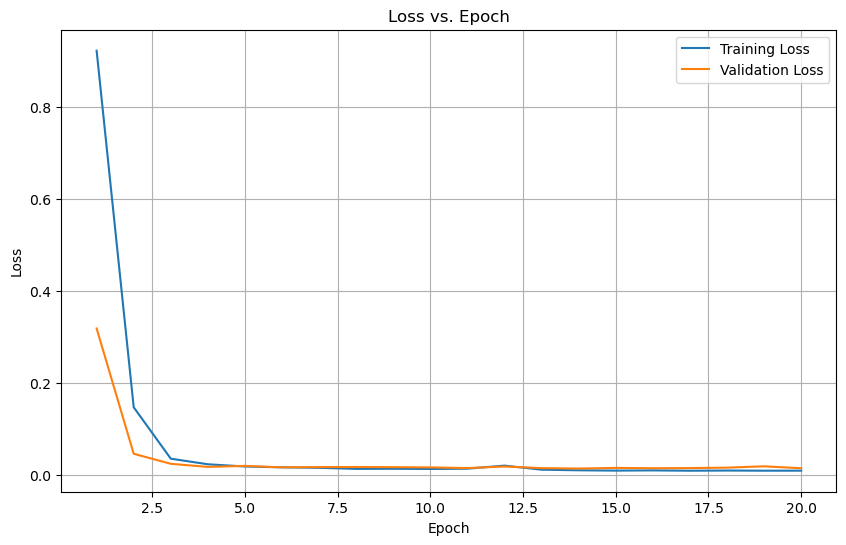

In [15]:
import matplotlib.pyplot as plt

# Plot Loss vs. Epoch
epochs = range(1, max_epoch + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
def exact_match(y_hat, yb):
    B = yb.shape[0] // 10       # Batch size

    correct = 0
    for i in range(B):
        f = True
        for j in range(10):
            if yb[i+(j*B)] != y_hat[i+(j*B)]:
                f = False
                break 
        if f: correct += 1

    output_correct = [0 for i in range(10)]
    for i in range(B):
        for j in range(10):
            if yb[i+(j*B)] == y_hat[i+(j*B)]:
                output_correct[j] += 1
    return correct, B, output_correct

val_labels = []
val_pred = []

val_epoch_loss = 0
correct_val, B_val = 0, 0
out_correct = [0 for i in range(10)]
with torch.no_grad():
    for xb, yb in tqdm(val_loader):
        xb = xb.to(device)
        yb = yb.to(device)

        y_hat = model(xb)
        loss = loss_fn(y_hat, yb)

        val_epoch_loss += float(loss)

        y_hat = torch.softmax(y_hat, dim = 1).argmax(dim=1)

        correct, B, output_correct = exact_match(y_hat, yb)
        correct_val += correct
        B_val += B
        for i in range(10):
            out_correct[i] += output_correct[i]

        val_labels.extend(yb.cpu().detach().numpy())
        val_pred.extend(y_hat.cpu().detach().numpy())

val_epoch_loss = val_epoch_loss / len(val_loader)
print("Test loss: ", val_epoch_loss)
print("Test accuracy: ", accuracy_score(val_labels, val_pred)*100)
print("Test EM: ", (correct_val/ B_val)*100)
for i in range(10):
    out_correct[i] = (out_correct[i] / B_val) * 100
print("Test accuracy position-wise: ", out_correct)

100%|█████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 51.91it/s]

Test loss:  0.01435844127414748
Test accuracy:  99.56375
Test EM:  96.35000000000001
Test accuracy position-wise:  [99.3625, 96.775, 99.9375, 99.6625, 100.0, 100.0, 99.9625, 100.0, 99.9875, 99.95]


In [17]:
# Calculate the average Exact Match Error
average_exact_match_error = (1 - (correct_val / B_val)) * 100

# Calculate the average Mismatch Error
average_mismatch_error = ((sum(out_correct) / 10) / B_val) * 100

# Find the output with the highest error
highest_error_output = out_correct.index(max(out_correct)) + 1

# Find the output with the lowest error
lowest_error_output = out_correct.index(min(out_correct)) + 1

# Print the results
print("Average Validation Set Error (Exact Match) in %:", average_exact_match_error)
print("Average Validation Set Error (Mismatch) in %:", average_mismatch_error)
print("Output with Highest Error:", highest_error_output)
print("Output with Lowest Error:", lowest_error_output)


Average Validation Set Error (Exact Match) in %: 3.6499999999999977
Average Validation Set Error (Mismatch) in %: 1.244546875
Output with Highest Error: 5
Output with Lowest Error: 2
